In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import sys

ROOT_DIR = os.path.abspath("../../")
SRC_DIR = os.path.join(ROOT_DIR, "src")

sys.path.append(SRC_DIR)

from dataset.dataset_interface import DatasetInterface
from utils.visualization_utils import to_rgb 
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

# Mask

In [5]:
THIRDPARTY_DIR = os.path.join(ROOT_DIR, "3rdparty/mask_rcnn")
sys.path.append(THIRDPARTY_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize, config
from samples.ycb.ycb_config import YCBConfig
# from samples.ycb.ycb_dataset import YCBDataset

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "resources/mask_rcnn/logs")
model_file = Path(THIRDPARTY_DIR + "/resources/ycb/mask_rcnn_ycb_video_dataset_0100.h5")

config = YCBConfig(gpus=1, imgs_per_gpu=1)
config.display()

model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)
model.load_weights(model_file.as_posix(), by_name=True)



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                34
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [6]:
from samples.ycb.ycb_dataset import YCBDataset

dataset = YCBDataset()
dataset.load_classes(THIRDPARTY_DIR + "/samples/ycb/data/YCB_Video_Dataset/annotations/val_instances.json")
dataset.prepare()

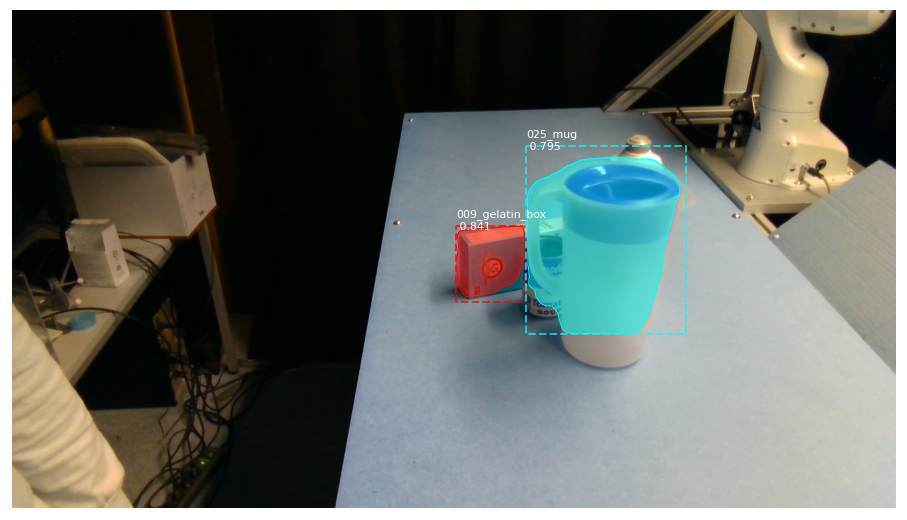

In [9]:
masked_frames = []
dataset_interface = DatasetInterface(Path(ROOT_DIR + "/resources/images/calibrated"))
idx = np.random.randint(len(dataset_interface), size=(1,)).item()
# for rs_rgb, rs_depth, zv_rgb, zv_depth in dataset_interface:
rs_rgb, rs_depth, zv_rgb, zv_depth = dataset_interface[idx]
original_image = zv_rgb
original_image = to_rgb(cv2.imread(ROOT_DIR + "/3rdparty/mask_rcnn/samples/ycb/rgb.png"))
results = model.detect([original_image])
r = results[0]

visualize.display_instances(original_image, 
r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])
mask = np.expand_dims(np.sum(r['masks'], axis=2) > 0, axis=2)
rs_rgb_masked = rs_rgb * mask
rs_depth_masked = np.expand_dims(rs_depth, axis=2) * mask
zv_rgb_masked = zv_rgb * mask
zv_depth_masked = np.expand_dims(zv_depth, axis=2) * mask
# 
# visualize.display_instances(rs_rgb_masked, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])
